In [1]:
import sys
import os
sys.path.append(os.path.abspath('/home/andyalyfsyah/FLUENT-Chatbot-2023/FLUENT_REFACTORED_24'))

In [14]:
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel, GPT2Tokenizer
from sklearn.decomposition import PCA
from torch import nn
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from data import qa_paired, qa_paired_eval
from architecture_5pre_bert import FLUENTSOTA
from evaluation_tool import calculate_bleu, count_bleu_score, compute_average_chrf, generate_predictions
from neptune_fluent import Neptune_Fluent 

import torch
import matplotlib.pyplot as plt
import time
import pandas as pd

encoder_id = 'indobenchmark/indobert-base-p1'
print("initiliazing encoder model and tokenizer : {}".format(encoder_id))
enc_tokenizer = AutoTokenizer.from_pretrained(encoder_id, clean_up_tokenization_spaces=True)
enc_model = AutoModel.from_pretrained(encoder_id)

decoder_id = 'indonesian-nlp/gpt2-medium-indonesian'
# decoder_id = 'cahya/gpt2-large-indonesian-522M'
print("initiliazing decoder model and tokenizer : {}".format(decoder_id))
dec_model = GPT2LMHeadModel.from_pretrained(decoder_id)
dec_tokenizer = GPT2Tokenizer.from_pretrained(decoder_id, clean_up_tokenization_spaces=True)

dec_tokenizer.add_tokens(['[PRE1]'])
dec_tokenizer.add_tokens(['[PRE2]'])
dec_tokenizer.add_tokens(['[PRE3]'])
dec_tokenizer.add_tokens(['[PRE4]'])
dec_tokenizer.add_tokens(['[PRE5]'])
dec_tokenizer.add_special_tokens({'pad_token': '[PAD]',
                                    'bos_token': '[BOS]',
                                    'eos_token': '[EOS]',
                                    'sep_token': '[SEP]',})
dec_model.config.pad_token_id = dec_tokenizer.pad_token_id
dec_model.config.bos_token_id = dec_tokenizer.bos_token_id
dec_model.config.eos_token_id = dec_tokenizer.eos_token_id
dec_model.config.sep_token_id = dec_tokenizer.sep_token_id
dec_model.resize_token_embeddings(len(dec_tokenizer))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
enc_model = enc_model.to(device)
dec_model = dec_model.to(device)
print("finished initiliazing encoder model and tokenizer")

for param in enc_model.parameters():
    param.requires_grad = False

for param in dec_model.parameters():
    param.requires_grad = False

for param in dec_model.transformer.h[:-15].parameters():
    param.requires_grad = True

for param in enc_model.encoder.layer[:-15].parameters():
    param.requires_grad = True

print("Encoder Trainable Parameters : {}%".format(sum(p.numel() for p in enc_model.parameters() if p.requires_grad)/sum(p.numel() for p in enc_model.parameters())*100))
print("Decoder Trainable Parameters : {}%".format(sum(p.numel() for p in dec_model.parameters() if p.requires_grad)/sum(p.numel() for p in dec_model.parameters())*100))

dec_size = 1280 if 'large' in decoder_id else 1024
model = FLUENTSOTA(enc_model, dec_model, enc_tokenizer, dec_tokenizer, dec_size)
model.to(device)

all_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
untrainable_params = all_params - trainable_params
print(f'All parameters: {all_params:,}')
print(f'Trainable parameters: {trainable_params:,} ({trainable_params/all_params*100:.2f}%)')
print(f'Untrainable parameters: {untrainable_params:,} ({untrainable_params/all_params*100:.2f}%)')

bleu_score_eval = pd.DataFrame(columns=['Epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])
bleu_score_train = pd.DataFrame(columns=['Epoch', '1-gram', '2-gram', '3-gram', '4-gram', 'cumulative-1-gram', 'cumulative-2-gram', 'cumulative-3-gram', 'cumulative-4-gram'])

questions = qa_paired['Pertanyaan'].apply(lambda x: x.lower().replace('[BOS]', '').replace('[EOS]', '')).to_list()
answers = qa_paired['Jawaban'].apply(lambda x: x.replace('[BOS]', '').replace('[EOS]', '').lower().strip()).to_list()
questions_eval = qa_paired_eval['Pertanyaan'].apply(lambda x: x.lower().replace('[BOS]', '').replace('[EOS]', '')).to_list()
answers_eval = qa_paired_eval['Jawaban'].apply(lambda x: x.replace('[BOS]', '').replace('[EOS]', '').lower().strip()).to_list()

epochs = 500
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
run = Neptune_Fluent.mulai(encoder_id, decoder_id, num_pre_token=3)
bleu_result_eval = {"cumulative-4-gram":0}
bleu_result_train = {"cumulative-4-gram":0}
chrf_result_eval = 0
chrf_result_train = 0

print("start training")
for ep in range(epochs):
    torch.cuda.empty_cache()

    total_loss = 0
    for instance in qa_paired.iterrows():
        # print("---------------")
        optimizer.zero_grad()

        pertanyaan = instance[1]['Pertanyaan']
        jawaban = instance[1]['Jawaban']
        jawaban_withpre = '[PRE1][PRE2][PRE3][PRE4][PRE5]' + jawaban

        tokenized_jawaban_withpre = model.dec_tokenizer(jawaban_withpre)
        tokenized_jawaban_withpre = torch.tensor(tokenized_jawaban_withpre['input_ids']).unsqueeze(0)

        enc_logits = model.encoding(pertanyaan)
        output = model.decoding_train(enc_logits, target=jawaban, target_with_pre=tokenized_jawaban_withpre)

        loss = output.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    run["train/loss"].append(total_loss)
    print(f'Epoch {ep+1}/{epochs} - Loss: {total_loss:.4f}')
    if (ep+1) % 10 == 0:
        print(f'\n-----------------------------------------')
        test_question = qa_paired['Pertanyaan'].iloc[0]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired['Pertanyaan'].iloc[1]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        test_question = qa_paired['Pertanyaan'].iloc[4]
        outputs = model.generate(test_question)
        decoded_output = model.dec_tokenizer.decode(outputs[0])
        print(f'Q >>> {test_question}')
        print(f'A <<< {decoded_output}')
        print(f'-----------------------------------------\n')

    # if (ep+1) % 100 == 0:
    #     preds_eval = generate_predictions(model, questions_eval)

    #     bleu_result_eval = calculate_bleu(preds_eval, questions_eval, answers_eval)
    #     bleu_score_eval = pd.concat([bleu_score_eval, pd.DataFrame({'Epoch': ep+1, **bleu_result_eval}, index=[len(bleu_score_eval)])], ignore_index=True)
    #     print(f'BLEU Score Eval: {bleu_result_eval["cumulative-4-gram"]:.4f}\n')

    #     chrf_result_eval = compute_average_chrf(preds_eval, answers_eval)
    #     print(f'CHRF Score Eval: {chrf_result_eval:.4f}\n')

    #     preds_train = generate_predictions(model, questions)
    #     bleu_result_train = calculate_bleu(preds_train, questions, answers)
    #     bleu_score_train = pd.concat([bleu_score_train, pd.DataFrame({'Epoch': ep+1, **bleu_result_train}, index=[len(bleu_score_train)])], ignore_index=True)
    #     print(f'BLEU Score Train: {bleu_result_train["cumulative-4-gram"]:.4f}\n')

    #     chrf_result_train = compute_average_chrf(preds_train, answers)
    #     print(f'CHRF Score Train: {chrf_result_train:.4f}\n')

    # run["eval/chrf"].append(chrf_result_eval)
    # run["train/chrf"].append(chrf_result_train)
    # run["eval/bleu"].append(bleu_result_eval["cumulative-4-gram"])
    # run["train/bleu"].append(bleu_result_train["cumulative-4-gram"])

run.stop()
print("finished training")

initiliazing encoder model and tokenizer : indobenchmark/indobert-base-p1
initiliazing decoder model and tokenizer : indonesian-nlp/gpt2-medium-indonesian
finished initiliazing encoder model and tokenizer
Encoder Trainable Parameters : 0.0%
Decoder Trainable Parameters : 31.94917406411248%
All parameters: 486,358,784
Trainable parameters: 120,451,072 (24.77%)
Untrainable parameters: 365,907,712 (75.23%)
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/andialifs/fluent-tesis-playground-24/e/FLUEN-85
start training
Epoch 1/500 - Loss: 332.9615
Epoch 2/500 - Loss: 321.1310
Epoch 3/500 - Loss: 362.3684
Epoch 4/500 - Loss: 429.7325
Epoch 5/500 - Loss: 456.2610
Epoch 6/500 - Loss: 440.9790
Epoch 7/500 - Loss: 436.1286
Epoch 8/500 - Loss: 423.2005
Epoch 9/500 - Loss: 392.9278
Epoch 10/500 - Loss: 385.4843

-----------------------------------------
Q >>> visi filkom
A <<< 


.itu dari
.itu dari padav
.itu
.itu
O[BOS][BOS][BOS] [PRE1] [PRE1] [PRE1] [BOS] [PRE1] [

KeyboardInterrupt: 

In [2]:
# save the model
torch.save(model.state_dict(), 'model_state_dict_best_2225.pth')

In [15]:
test_question = "apa visi filkom"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

Q >>> apa visi filkom
A <<< ,[BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS]: adalah, “s[BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS]:
, yang, dari, adalah:
,.,[BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][BOS][B

In [11]:
test_question = "apa email pak fitra"
outputs = model.generate(test_question)
decoded_output = model.dec_tokenizer.decode(outputs[0])
print(f'Q >>> {test_question}')
print(f'A <<< {decoded_output}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x768 and 1024x1024)

In [6]:
questions_eval

['apa visi fakultas',
 'visi dari filkom',
 'apa saja visi filkom',
 'apa misi fakultas',
 'apa saja misi flkom',
 'apa misi filkom',
 'bagaimana tujuan filkom',
 'apa tujuan filkom',
 'pendidikan saran filkom',
 'apa saja sasaran dari filkom',
 'apa sasaran pendidikan filkom',
 'apa email pak fitra',
 'email e pak fitra teh naon',
 'apa email fitra a. bachtiar',
 'pak fitra penelitian di bidang apa',
 'bidang penelitian pak fitra',
 'tanggal tanggal pembentukan ptiik',
 'tanggal dibentuk ptiik',
 'sasaran filkom untuk pengabdian apa saja',
 'apa saja sasaran pengabdian filkom',
 'sasaran dari kerjasama filkom apa saja ya',
 'apa saja sasaran kerjasama filkom',
 'dekan filkom the saha',
 'siapa dekan fakultas ilmu komputer filkom',
 'wajuk dekan 1 filkom saha',
 'wakil dekan bidang akademik filkom siapa ya',
 'siapa wakil dekan 2 filkom',
 'wakil dekan bidang umum, keuangan, dan sumber daya / wakil dekan 2',
 'siapa wakil dekan bidang kemahasiswaan 3',
 'wakil dekan bidang kemahasiswaa

In [24]:
test_question = [
    "apa visi filkom",
    "sebutkan visi filkom",
    "apa visi fakultas",
    "apa misi filkom",
    "sebutkan misi fakultas",
    "apa email pak fitra",
    "email fitra",
    "wd 1 akademik filkom",
    "siapa wd akademik",
    "wd 1 teh saha"
]

labels = ["visi"] * 3 + ["misi"] * 2 + ["email"] * 2 + ["wd_akademik"] * 3

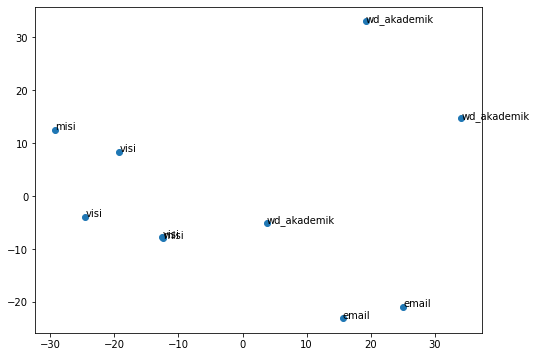

In [25]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

encoded = model.encoding(test_question)

pca = PCA(n_components=2)

enc_2d = pca.fit_transform(encoded.detach().cpu().numpy())

plt.figure(figsize=(8,6))
plt.scatter(enc_2d[:,0], enc_2d[:,1])
for i, txt in enumerate(labels):
    plt.annotate(txt, (enc_2d[i,0], enc_2d[i,1]))


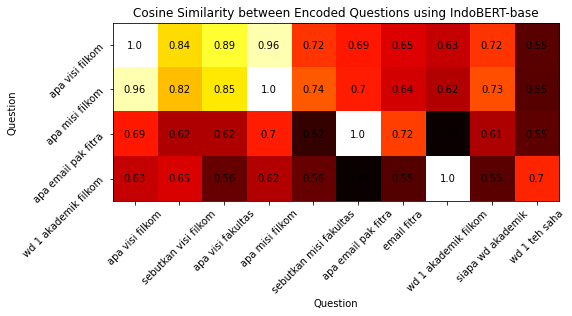

In [26]:
encoded.shape

# for each in encoded, it calculate the distance to the other encoded

from sklearn.metrics.pairwise import cosine_similarity

cs = cosine_similarity(encoded.detach().cpu().numpy(), encoded.detach().cpu().numpy())

question_train_index = [0,3,5,7]
# delete except question_train_index in columns
cs = cs[question_train_index, :]

# display in a heatmap
plt.figure(figsize=(8,6))
plt.imshow(cs, cmap='hot', interpolation='nearest')
plt.xlabel('Question')
plt.ylabel('Question')
plt.title('Cosine Similarity between Encoded Questions using IndoBERT-base')

# make x and y labels
plt.yticks(range(len(question_train_index)), [test_question[i] for i in question_train_index], rotation=45)
plt.xticks(range(len(test_question)), [test_question[i] for i in range(len(test_question))], rotation=45)

# add labels to the heatmap
for i in range(len(test_question)):
    for j in range(len(question_train_index)):
        plt.text(i, j, round(cs[j,i],2), ha='center', va='center', color='black')

# plt.colorbar()
plt.show()